In [1]:
import torch
import numpy as np
from torch_geometric.loader import DataLoader

%reload_ext autoreload
%autoreload 2


## Test

In [2]:
import scipy.io
import os

file_name = 'cf_data_1000_6_30'
mat_data = scipy.io.loadmat('Data/' + file_name + '.mat')
mat_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Phii_cf', 'R_cf_opt_min', 'betas'])

In [3]:
beta_all = mat_data['betas']
phi_all = mat_data['Phii_cf'].transpose(0,2,1)
min_rate = mat_data['R_cf_opt_min'].T

# Parameters


In [5]:
_, _, num_sam, num_UE, num_AP = file_name.split('_')
num_sam = int(num_sam)
num_UE = int(num_UE)
num_AP  = int(num_AP) 

In [6]:

# num_UE = 5 # number of terminals
# num_AP = 30 # number of access points
num_antenna = 50
tau=20; power_f=0.2; D=1; f=1900; Hb=15; Hm=1.65; d0=0.01;d1=0.05;

# random_matrix = np.random.randn(tau, tau)
# U, S, V = np.linalg.svd(random_matrix)

# Hb = 15 # Base station height in m
# Hm = 1.65 # Mobile height in m
# f = 1900 # Frequency in MHz
# aL = (1.1 * np.log10(f) - 0.7) * Hm - (1.56 * np.log10(f) - 0.8)
# L = 46.3+33.9*np.log10(f)-13.82*np.log10(Hb)-aL

power_f=0.2 # downlink power
rho_p, rho_d = power_f, power_f

# Pd = power_f / 10 ** ((-203.975 + 10 * np.log10(20 * 10 ** 6) + 9) / 10) # normalized receive SNR
Ther_noise = 20000000 * 10**(-17.4) * 10**-3
Pd = 1/Ther_noise
Pu=Pd

d0=0.01 # km
d1=0.05 # km




In [7]:
num_train = 500
num_test = 200
batchSize = 32

lr = 1e-4
step_size = 5
gamma = 0.9

# FL
num_rounds = 5

num_client = num_AP 
num_epochs = 10
eval_round = num_rounds//10 if num_rounds//10 else 1

# Create data loader for training and testing 

In [8]:
from Utils.data_gen import Generate_Input, create_graph

# Beta_all, Phi_all = Generate_Input(num_train, tau, num_UE, num_AP, Pd, D=1, Hb=15, Hm=1.65, f=1900,
#                     var_noise=1, Pmin=0, seed=2017, d0=d0, d1=d1)
Beta_all, Phi_all = beta_all[:num_train], phi_all[:num_train]
train_data = create_graph(Beta_all, Phi_all, 'het')
train_loader = [
    DataLoader(train_data[i], batch_size=batchSize, shuffle=True)
    for i in range(num_AP)
]


# Beta_test, Phi_test = Generate_Input(num_test, tau, num_UE, num_AP, Pd, D=1, Hb=15, Hm=1.65, f=1900,
#                     var_noise=1, Pmin=0, seed=2017, d0=d0, d1=d1)
Beta_test, Phi_test = beta_all[-num_test:], phi_all[-num_test:]
test_data = create_graph(Beta_test, Phi_test, 'het')
test_loader = [
    DataLoader(test_data[i], batch_size=batchSize, shuffle=False)
    for i in range(num_AP)
]


train_data_cen = create_graph(Beta_all, Phi_all, 'het', isDecentralized=False)
train_loader_cen = DataLoader(train_data_cen, batch_size=batchSize, shuffle=True)
test_data_cen = create_graph(Beta_test, Phi_test, 'het', isDecentralized=False)
test_loader_cen = DataLoader(test_data_cen, batch_size=batchSize, shuffle=False)

/home/wine-4/miniconda3/envs/GNN_FL/lib/python3.10/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [9]:
hidden_channels = 32 # > 4
num_gnn_layers = 2


ap_dim = train_data[0][0]['AP'].x.shape[1]
ue_dim = train_data[0][0]['UE'].x.shape[1]
edge_dim = train_data[0][0]['down'].edge_attr.shape[1]
tt_meta = [('UE', 'up', 'AP'), ('AP', 'down', 'UE')]
dim_dict = {
    'UE': ue_dim,
    'AP': ap_dim,
    'edge': edge_dim,
}

In [10]:
from Models.GNN import APHetNet

model = APHetNet(
    metadata=tt_meta,
    dim_dict=dim_dict,
    out_channels=hidden_channels,
    num_layers=num_gnn_layers,
    hid_layers=hidden_channels
)

In [11]:
from Models.GNN import APHetNet
from Utils.training import train, eval, package_calculate
from Utils.synthetic_graph import return_graph, combine_graph

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

global_model = APHetNet(
    metadata=tt_meta,
    dim_dict=dim_dict,
    out_channels=hidden_channels,
    num_layers=num_gnn_layers,
    hid_layers=hidden_channels
).to(device)
local_models, optimizers = [], []

# Init every client model/optimizer
for each_AP in range(num_AP):
    model = APHetNet(
        metadata=tt_meta,
        dim_dict=dim_dict,
        out_channels=hidden_channels,
        num_layers=num_gnn_layers,
        hid_layers=hidden_channels
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    local_models.append(model)
    optimizers.append(optimizer)

# Main Training

In [ ]:
import copy
from Utils.training import (
    get_global_info, distribute_global_info, average_weights,
    fl_train,  fl_eval_rate
)

log = []

print(f"Starting Federated Learning with {num_client} clients for {num_rounds} rounds")

for round in range(num_rounds):
    # print(f"\n=== Federated Round {round+1}/{num_rounds} ===")
    
    ## 1.Exchange global information
    send_to_server = get_global_info(
        train_loader, local_models, optimizers,
        tau=tau, rho_p=power_f, rho_d=power_f
    )
    response_all = distribute_global_info(send_to_server)
    
    
    ## 2. Training Local models    
    local_weights = []
    total_loss = 0.0
    for model, opt, batches , responses_ap in zip(local_models, optimizers, train_loader, response_all):
        model.train() 
        opt.zero_grad() 
        for epoch in range(num_epochs):
            train_loss = fl_train(
                batches, responses_ap, model, opt,
                tau=tau, rho_p=power_f, rho_d=power_f, num_antenna=num_antenna
            )
        local_weights.append(copy.deepcopy(model.state_dict()))
        total_loss += train_loss
    avg_loss = total_loss / num_client
    # print(f"Round {round+1}: Average local training loss = {avg_loss:.6f}")


    ## 3. Update global models
    global_weights = average_weights(local_weights)

    # Broadcast updated global weights to all clients
    for model in local_models:
        model.load_state_dict(global_weights)
        

    ## 4. Exchange global eval information
    # print("Evaluating global model(s)...")
    # send_to_server_eval = get_global_info(
    #     test_loader, local_models, optimizers,
    #     tau=tau, rho_p=power_f, rho_d=power_f
    # )
    # response_all_eval = distribute_global_info(send_to_server_eval)
    # total_eval_rate = 0.0
    # for client_idx, (model, loader, responses) in enumerate(zip(local_models, test_loader, response_all_eval)):
    #     model.eval() 
    #     for epoch in range(num_epochs):
    #         eval_metrics = fl_eval(
    #             loader, responses, model,
    #             tau=tau, rho_p=power_f, rho_d=power_f, num_antenna=num_antenna
    #         )
    #     total_eval_rate += eval_metrics
    # total_eval_rate = total_eval_rate/num_client
    #     # print(f"Client {client_idx}: {eval_metrics}")
    
    
    total_eval_rate = fl_eval_rate(
        test_loader, local_models,
        tau=tau, rho_p=power_f, rho_d=power_f, num_antenna=num_antenna
    )
    if round%eval_round==0:
        print(f"Round {round+1:02d}/{num_rounds}: Avg Training Rate = {-avg_loss:.6f} | Avg Eval rate = {total_eval_rate:.6f}")
            
    log.append({
        "round": round + 1,
        "train_loss": avg_loss,
        "eval": total_eval_rate
    })
    

Starting Federated Learning with 30 clients for 5 rounds


# Centralized training

In [ ]:
from Models.GNN import APHetNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR

cen_model = APHetNet(
    metadata=tt_meta,
    dim_dict=dim_dict,
    out_channels=hidden_channels,
    num_layers=num_gnn_layers,
    hid_layers=hidden_channels,
    edge_conv=True
).to(device)
cen_optimizer = torch.optim.Adam(cen_model.parameters(), lr=lr)
cen_scheduler = StepLR(cen_optimizer, step_size=10, gamma=0.5)

In [143]:
num_epochs = 500
eval_epochs = num_epochs//10 if num_epochs//10 else 1

In [144]:
from Utils.training import cen_eval, cen_train
for epoch in range(num_epochs):
    cen_model.eval()
    with torch.no_grad():
        train_eval = cen_eval(
            train_loader_cen, cen_model,
            tau=tau, rho_p=power_f, rho_d=power_f, num_antenna=num_antenna
        )
        test_eval = cen_eval(
            train_loader_cen, cen_model,
            tau=tau, rho_p=power_f, rho_d=power_f, num_antenna=num_antenna
        )
    cen_model.train()
    train_loss = cen_train(
        train_loader_cen, cen_model, cen_optimizer,
        tau=tau, rho_p=power_f, rho_d=power_f, num_antenna=num_antenna
    )
    cen_scheduler.step()
    if epoch%eval_epochs==0:
        print(
            f"Epoch {epoch+1:03d}/{num_epochs} | "
            f"Train Loss: {train_loss:.6f} | "
            f"Train Rate: {train_eval:.6f} | "
            f"Test Rate: {test_eval:.6f} "
        )

Epoch 001/500 | Train Loss: -1.883581 | Train Rate: 1.527065 | Test Rate: 1.527065 
Epoch 051/500 | Train Loss: -3.237994 | Train Rate: 3.456835 | Test Rate: 3.456835 
Epoch 101/500 | Train Loss: -3.276543 | Train Rate: 3.530913 | Test Rate: 3.530913 
Epoch 151/500 | Train Loss: -3.316487 | Train Rate: 3.482030 | Test Rate: 3.482030 
Epoch 201/500 | Train Loss: -3.290830 | Train Rate: 3.491651 | Test Rate: 3.491651 
Epoch 251/500 | Train Loss: -3.306189 | Train Rate: 3.490916 | Test Rate: 3.490917 
Epoch 301/500 | Train Loss: -3.298980 | Train Rate: 3.500457 | Test Rate: 3.500457 
Epoch 351/500 | Train Loss: -3.321984 | Train Rate: 3.400666 | Test Rate: 3.400666 
Epoch 401/500 | Train Loss: -3.294988 | Train Rate: 3.477033 | Test Rate: 3.477033 
Epoch 451/500 | Train Loss: -3.307991 | Train Rate: 3.491961 | Test Rate: 3.491960 


In [160]:
eval_file_name = 'cf_data_200_6_30'
eval_mat = scipy.io.loadmat('Data/' + eval_file_name + '.mat')
Beta_eval = eval_mat['betas']
Phi_eval = eval_mat['Phii_cf'].transpose(0,2,1)

In [161]:
num_eval = 200

In [168]:
Phi_eval.shape

(200, 6, 20)

In [162]:
eval_data = create_graph(Beta_eval, Phi_eval, 'het')
eval_loader = [
    DataLoader(eval_data[i], batch_size=num_eval, shuffle=False)
    for i in range(num_AP)
]

eval_data_cen = create_graph(Beta_eval, Phi_eval, 'het', isDecentralized=False)
eval_loader_cen = DataLoader(eval_data_cen, batch_size=num_eval, shuffle=True)

In [163]:
from Utils.training import cen_loss_function

cen_model.eval()
for batch in eval_loader_cen:
    batch = batch.to(device)
    num_graph = batch.num_graphs
    x_dict, edge_dict, edge_index = cen_model(batch)
    
    gnn_rates = cen_loss_function(
            batch, x_dict, edge_dict,
            tau=tau, rho_p=rho_p, rho_d=rho_d, num_antenna=num_antenna, eval_mode=True
        ).detach().numpy() 
    
    # gnn_rates = rate_loss(output, d_test, c_test, True).flatten().detach().numpy()

    # full = torch.ones_like(output)
    # all_one_rates = rate_loss(full, d_test, c_test, True).flatten().numpy()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (36000x21 and 11x64)

In [164]:
opt_rates = eval_mat['R_cf_opt_min'].T[:,0]

In [165]:
min_rate, max_rate = 0, 2
y_axis = np.arange(0, 1.0, 1/202)
gnn_rates.sort();  opt_rates.sort()
gnn_rates = np.insert(gnn_rates, 0, min_rate); gnn_rates = np.insert(gnn_rates,201,max_rate)
#all_one_rates = np.insert(all_one_rates, 0, min_rate); all_one_rates = np.insert(all_one_rates,201,max_rate)
opt_rates = np.insert(opt_rates, 0, min_rate); opt_rates = np.insert(opt_rates,201,max_rate)

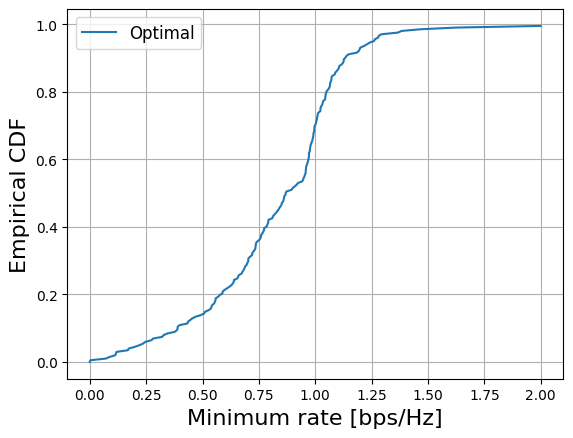

In [167]:
import matplotlib.pyplot as plt
# plt.plot(gnn_rates, y_axis, label = 'GNN')
plt.plot(opt_rates, y_axis, label = 'Optimal')
#plt.plot(all_one_rates, y_axis, label = 'Maximum Power')
plt.xlabel('Minimum rate [bps/Hz]', {'fontsize':16})
plt.ylabel('Empirical CDF', {'fontsize':16})
plt.legend(fontsize = 12)
plt.grid()